**Batch Detect Puncta v1.4**

Aim: Detect puncta for a whole field of view!!

- added stdev and median calculation from region props (excludes 0=value pixels)
- tidied up since v1.2
- added seaborn

STILL TO DO
 - There is an issue with the watershedding of Exp0106

In [1]:
import os
import numpy as np
import pandas as pd
import time
import skimage.io as io
io.use_plugin('tifffile')
import glob
from skimage import morphology
import mahotas as mh
from skimage.filters import threshold_adaptive
from scipy.ndimage import distance_transform_edt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.measure import regionprops

from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage

**Define Functions**

In [2]:
# import skimage.io as io
# io.use_plugin('tifffile')

#load Hoechst and GFP stacks from .ome.tif files
def load_ome(ome_stack_file):

    #MMStack .ome.tif files load channel,z,y,x
    #Check file contains .ome.tif
    if '.ome.tif' in ome_stack_file:

        #Load the file
        im=io.imread(ome_stack_file)

        #Select Hoechst stack
        if len(im.shape)==4:
            C1 = im[0,:,:,:]     #Channel = 0
            C2 = im[1,:,:,:]     #Channel = 1            
        if len(im.shape)==3:
            frames=im.shape[0]
            C1 = im[:(frames/2),:,:]     #Channel = 0
            C2 = im[(frames/2):,:,:]     #Channel = 1
            
        else:
            print 'unexpected channel organisation'
            
        #return split Channels
        return [C1, C2]
        
    else:
        print 'this is not an ome.tif'

In [3]:
#Generate crop coordinates from the pandas data frame for a given index
def crop_crds(hull_index):

    #Use 'icol' to query pd.df 'Hull_Properties' with an integer
    Hull=Hull_Properties.iloc[hull_index]

    #Calculate cropped image coordinates
    z = int(Hull[2])
    y_min = int(Hull[1]-256)
    y_max = int(Hull[1]+256)
    x_min = int(Hull[0]-256)
    x_max = int(Hull[0]+256)
    
    return (z, y_min, y_max, x_min, x_max)

In [4]:
#from skimage.filters import threshold_adaptive
#block_size and offset are optional arguments, with default parameters 35 and -20 respectively   
#block_size = Width of neighbourhood in pixels. Default was 35. I have set it to 9 for KDM5A puncta (even detects the hollow donuts)
#offset = Constant subtracted from mean. Default was 10. I have set it to -40 for GFP

#local threshold each frame in the stack
def localThreshStack(stack, block_size = 9, offset = -40):

    #Must be a 2D array
    if len(stack.shape)>2:
        mask=np.zeros_like(stack)

        for z, frame in enumerate(stack):
            #print(z)
            mask[z] = threshold_adaptive(frame, block_size, 'mean', offset)
        return mask     
    else:
        print 'Input is not a 3D stack'
        return threshold_adaptive(stack, block_size, 'mean', offset)

In [5]:
def getHullProperties(intensity_image, label_image):
    
    props=[]
    heading=["Hull", "Center_x", "Center_y", "Center_z", "volume",  "integrated_GFP", "mean_GFP", "std_GFP", "median_GFP", "threshold_GFP"]

    #Measure hull properties
    hull_props=regionprops(label_image, intensity_image)

    for h in hull_props:

        #Get bounding box
        bb=np.array(h.bbox)
        #zmin, ymin, xmin, zmax, ymax, xmax  = h.bbox

        #Calculate Center
        zcent=int(round((bb[0]+bb[3])/2))
        ycent=int(round((bb[1]+bb[4])/2))
        xcent=int(round((bb[2]+bb[5])/2))

        #Calculate stdev and median
        mask = h.intensity_image != 0

        std = np.std(h.intensity_image[mask])
        median = np.median(h.intensity_image[mask])

        #Calculate threshold
        thresh=median+(1.5*std)

        props.append([int(h.label),
                      xcent,
                      ycent,
                      zcent,
                      h.area,
                      h.mean_intensity * h.area,
                      h.mean_intensity,
                      std,
                      median,
                      thresh])

    return pd.DataFrame(props, columns=heading)

Rename variables to make detectPuncta generic

In [6]:
def detectPuncta(GFP_stack, hulls):
       
    #Find Puncta by adaptive thresholding
    GFP_mask3 = localThreshStack(GFP_stack)
    
    ##Intersect GFP mask with convex hulls to get GFP_mask5
    GFP_mask5 = GFP_mask3 * (hulls>0)

    ##Calculate 3D distance transform (slow)
    #from scipy.ndimage import distance_transform_edt
    blob_dis = distance_transform_edt(GFP_mask5)

    #Limit to >1 to isolate blobs
    iso_blobs = blob_dis>1

    #Label GFP regions (quick)
    GFP_blobs, n_blobs = mh.label(iso_blobs)
    print n_blobs
    
    #Filter by size
    #from mahotas.labeled import filter_labeled
    filt_blobs, _ = mh.labeled.filter_labeled(GFP_blobs, min_size=8)              #Variable min_size

    #Reset counts and count the labels, 
    real_blobs, n_blobs_left = mh.labeled.relabel(filt_blobs)
    print n_blobs_left
    
    #Return labeled puncta 'real_blobs'
    return real_blobs
    #return [n_blobs, n_blobs_left, real_blobs]  

In [7]:
def detectPuncta_v2(GFP_stack, hulls, min_size=8):
    
    #Mask external volume before thresholding
    import numpy.ma as ma    
    GFP_mask2 = ma.array(GFP_stack, mask = hulls==0)
       
    #Find Puncta by adaptive thresholding
    GFP_mask3 = localThreshStack(GFP_mask2)
    
    ##Intersect GFP mask with convex hulls to get GFP_mask5
    GFP_mask5 = GFP_mask3 * (hulls>0)

    ##Calculate 3D distance transform (slow)
    #from scipy.ndimage import distance_transform_edt
    blob_dis = distance_transform_edt(GFP_mask5)

    #Limit to >1 to isolate blobs
    iso_blobs = blob_dis>1

    #Label GFP regions (quick)
    GFP_blobs, n_blobs = mh.label(iso_blobs)
    
    #Filter by size
    #from mahotas.labeled import filter_labeled
    filt_blobs, _ = mh.labeled.filter_labeled(GFP_blobs, min_size)              #Variable min_size

    #Reset counts and count the labels, 
    real_blobs, n_blobs_left = mh.labeled.relabel(filt_blobs)
    
    #Return labeled puncta 'real_blobs'
    return real_blobs
    #return [n_blobs, n_blobs_left, real_blobs]    

In [8]:
def detectPuncta_v3(GFP_stack, hulls):
    
    #Mask external volume before thresholding
    for obj in range(1,hulls.max()+1):
       
        #Find Puncta by adaptive thresholding
        GFP_mask3 = localThreshStack(GFP_mask2)

        ##Intersect GFP mask with convex hulls to get GFP_mask5
        GFP_mask5 = GFP_mask3 * (hulls>0)

        ##Calculate 3D distance transform (slow)
        #from scipy.ndimage import distance_transform_edt
        blob_dis = distance_transform_edt(GFP_mask5)

        #Limit to >1 to isolate blobs
        iso_blobs = blob_dis>1

        #Label GFP regions (quick)
        GFP_blobs, n_blobs = mh.label(iso_blobs)

        #Filter by size
        #from mahotas.labeled import filter_labeled
        filt_blobs, _ = mh.labeled.filter_labeled(GFP_blobs, min_size=27)              #Variable min_size

        #Reset counts and count the labels, 
        real_blobs, n_blobs_left = mh.labeled.relabel(filt_blobs)
    
    #Return labeled puncta 'real_blobs'
    return real_blobs
    #return [n_blobs, n_blobs_left, real_blobs]  

In [9]:
def getPunctaProperties(intensity_image, label_image):

    #Get puncta properties
    props=[]
    heading=["Puncta", "Center_x", "Center_y", "Center_z", "volume", "mean_GFP", "integrated_GFP"]

    punc_props = regionprops(label_image, intensity_image)

    for p in punc_props:

        #Get bounding box
        bb=np.array(p.bbox)
        #zmin, ymin, xmin, zmax, ymax, xmax  = h.bbox

        #Calculate Center
        zcent=int(round((bb[0]+bb[3])/2))
        ycent=int(round((bb[1]+bb[4])/2))
        xcent=int(round((bb[2]+bb[5])/2))

        props.append([int(p.label),
                      xcent,
                      ycent,
                      zcent,
                      p.area,
                      p.mean_intensity,
                      p.mean_intensity * p.area])
    
    return pd.DataFrame(props, columns=heading)

In [10]:
##Find out which hull each puncta belongs to.
def assignPuncta(puncta_image, hull_image):

    loc=[]
    #Get puncta properties, by using labeled hull as the intensity image 
    punc_loc=regionprops(label_image=puncta_image, intensity_image=hull_image)

    for p in punc_loc:        
        loc.append(int(p.mean_intensity))
    return loc

In [11]:
##Define a generic puncta/Hull function
def PunctaByHull(Puncta_Properties_Column_Name, Hull_Properties_Column_Name):
    return np.divide(np.array(Puncta_Properties[Puncta_Properties_Column_Name].astype(float)),np.array(Hull_Properties.loc[Puncta_Properties["Hull"],Hull_Properties_Column_Name].astype(float)))

In [32]:
##Iterate through a filelist and concatenate data
#GFP = C1, Hoechst = C2 as in Exp0106

def batchDetectPuncta(filelist, hull_list, newpath):
    
    All_Hulls=pd.DataFrame()
    All_Spots=pd.DataFrame()

    for ff in range(len(filelist)):
        filepath=filelist[ff]
        filename = os.path.basename(filepath)

        #Remove microscope suffix
        stackname = filename.replace('_MMStack_Pos0.ome.tif', '')
        print(stackname)

        #Extract well number
        lowname=stackname.lower()
        well = stackname[lowname.index('well'):lowname.index('well')+6]

        #Extract stack number
        #stack = anything after the last '_'
        #use reverse find 'rfind' 
        stack = stackname[stackname.rfind("_")+1:]

        #Generate filename for Labeled Puncta
        Punctafilename = filename.replace('_MMStack_Pos0.ome.tif', '_Puncta')

        #Generate path for Labeled Puncta
        PunctaPath = newpath+Punctafilename

        #Identify the cognate shell mask
        matching = [s for s in hull_list if stackname in s]

        if (len(matching) != 1):
            print "There is no unique hull file for this input image"
        else:
            hullpath = matching[0]
            hullname = os.path.basename(hullpath)
            print(hullname) 

            #Extract channel information for a given file
            #[Hoechst_stack, GFP_stack] = load_ome(filepath)
            [GFP_stack, Hoechst_stack] = load_ome(filepath)

            #Load hulls
            hulls = np.load(hullpath)

            #Measure and collect Hull_Properties
            Hull_Properties = getHullProperties(GFP_stack, hulls)

            #Pass the current Well and Stack ID adding to the lefthand side
            Hull_Properties.insert(0, "Stack", int(stack))
            Hull_Properties.insert(0, "Well", well)

            #Save Hull Properties in the output directory
            HullPath=PunctaPath.replace("_Puncta","_Hull")
            Hull_Properties.to_csv(HullPath+"_Properties.csv")

            #Add Hull_Properties for the current file to the list
            All_Hulls=All_Hulls.append(Hull_Properties)

            #Detect and label puncta from the intensity image within the convex hulls
            real_blobs = detectPuncta(GFP_stack, hulls)

            ##Save puncta
            np.save(PunctaPath, real_blobs)

            #Measure and collect Puncta_Properties
            Puncta_Properties = getPunctaProperties(GFP_stack, real_blobs)

            #Assign each puncta to its cognate hull
            Puncta_Properties.insert(0, "Hull", pd.to_numeric(assignPuncta(real_blobs, hulls)))

            #Pass the current Well and Stack ID adding to the lefthand side
            Puncta_Properties.insert(0, "Stack", int(stack))
            Puncta_Properties.insert(0, "Well", well)

            #Save Puncta_Properties in the output directory
            Puncta_Properties.to_csv(PunctaPath+"_Properties.csv")

            #Add Puncta_Properties for the current file to the list
            All_Spots=All_Spots.append(Puncta_Properties)

    print "Processed"
    return [All_Hulls, All_Spots]

In [13]:
def clusterMarkers(markers, collections):

    ##Cluster in z
    marker_props = regionprops(markers, collections) #Use filled mask as intensity image to preserve original labeling

    m_head=['Marker','x','y','z','Collection']
    m_props=[]

    for m in marker_props:

        #Get bounding box
        bb=np.array(m.bbox)
        #zmin, ymin, xmin, zmax, ymax, xmax  = h.bbox

        #Calculate Center
        zcent=int(round((bb[0]+bb[3])/2))
        ycent=int(round((bb[1]+bb[4])/2))
        xcent=int(round((bb[2]+bb[5])/2))


        m_props.append([int(m.label),
                          xcent,
                          ycent,
                          zcent,
                          m.mean_intensity])
        
    return pd.DataFrame(m_props, columns=m_head)

In [14]:
def watershed3D(big):

    #Calculate 3D distance transform of labeled image
    print 'calculating distance transform'
    distance = ndimage.distance_transform_edt(big)
    
    #Detect local maxima
    print 'calculating distance maxima'
    local_max10 = peak_local_max(distance, indices=False, threshold_abs=5, footprint=np.ones((1, 150, 150)), labels=big)
    
    #Dilate maxima in 3D to collect nearby markers together
    collect=morphology.binary_dilation(local_max10.max(axis=0), np.ones((15,15)))
    collect3D = np.repeat(collect[np.newaxis, :, :], 24, axis=0)
    
    ##Count collections
    collections, n_collections=mh.label(collect3D)
    
    ##Count markers
    markers, n_markers=mh.label(local_max10)
    
    #Tabulate Marker Properties
    Marker_Properties = clusterMarkers(markers, collections)
    
    #Average markers if they are within the same collection
    center_positions = Marker_Properties.groupby('Collection', as_index=False)['x','y','z'].mean().astype(int)
    
    #Make 3D binary
    centers=np.zeros_like(big)

    #Specify True values based on coodinate list
    centers[center_positions['z'], center_positions['y'], center_positions['x']] = center_positions['Collection']

    ##3D watershed with unique centers
    return watershed(image = -distance, markers = centers, mask=big)

**Set input and output directories**

In [15]:
#[2] Get targeted filelist

#path='C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/'
path='C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5/'

target='.ome.tif'

filelist=glob.glob(path+str('*')+target)

In [16]:
filelist

['C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5\\Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_000_000.ome.tif',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5\\Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_000_001.ome.tif',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5\\Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_000_002.ome.tif',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5\\Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_001_000.ome.tif',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5\\Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_001_001.ome.tif',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5\\Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_001_002.ome.tif',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5\\Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_002_000.ome.tif',
 'C:/Users/Da

In [17]:
#[3] Get shell list
shell_list=glob.glob(path+str('/Output/Shells/*Split_Shells.npy'))

In [18]:
#[4] Specify output directory
output='PunctaByShell/'
newpath = path+output
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [19]:
shell_list

['C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5//Output/Shells\\Well01_HEK293T_eGFP-KDM5A_0_Split_Shells.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5//Output/Shells\\Well01_HEK293T_eGFP-KDM5A_1_Split_Shells.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5//Output/Shells\\Well01_HEK293T_eGFP-KDM5A_2_Split_Shells.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5//Output/Shells\\Well01_HEK293T_eGFP-KDM5A_3_Split_Shells.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5//Output/Shells\\Well01_HEK293T_eGFP-KDM5A_4_Split_Shells.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5//Output/Shells\\Well01_HEK293T_eGFP-KDM5A_5_Split_Shells.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5//Output/Shells\\Well01_HEK293T_eGFP-KDM5A_6_Split_Shells.npy']

**Operate on test case**

In [20]:
case=2

In [21]:
#Test
shells = np.load(shell_list[case])
[GFP_stack, Hoechst_stack] = load_ome(filelist[case])

C:\Users\David Brown\Anaconda2\lib\site-packages\skimage\external\tifffile\tifffile.py:1106: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn("ome-xml: not an ome-tiff master file")


(<matplotlib.axes._subplots.AxesSubplot at 0x196b9898>,
 (-0.5, 2047.5, 2047.5, -0.5))

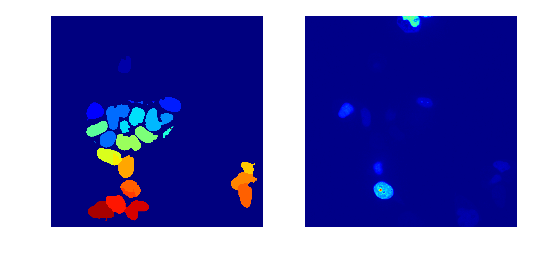

In [78]:
#Compare side by side
plt.subplot(1,2,1), plt.imshow(shells[25])
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,2), plt.imshow(GFP_stack[8])
plt.subplot(1,2,2), plt.axis('off')

##Lower the watershed threshold, and use convexhulls for smaller nuclei

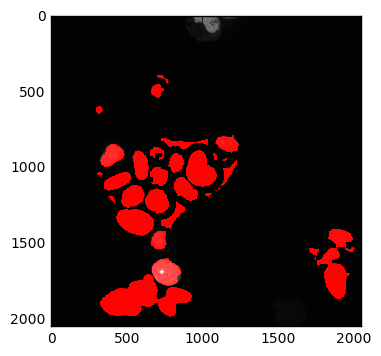

In [23]:
plt.imshow(mh.overlay(GFP_stack[8], shells[8]))

In [24]:
#Measure and collect Hull_Properties
Shell_Properties = getHullProperties(GFP_stack, shells)

In [25]:
Shell_Properties

,Hull,Center_x,Center_y,Center_z,volume,integrated_GFP,mean_GFP,std_GFP,median_GFP,threshold_GFP
0,1,710,477,17,407159,70593554.0,173.380802,26.189977,177.0,216.284965
1,2,319,626,7,14409,1566929.0,108.746547,5.617497,108.0,116.426246
2,3,682,916,17,656932,535977599.0,815.879876,339.956282,873.0,1382.934422
3,4,991,864,17,655442,248918593.0,379.772113,118.597136,400.0,577.895704
4,5,862,877,17,153204,18325700.0,119.616329,8.564670,119.0,131.847006
5,6,611,1070,17,1592873,289940176.0,182.023411,92.778361,120.0,259.167541
6,7,768,1075,17,236973,87698210.0,370.076802,154.343689,421.0,652.515534
7,8,989,1009,17,1009655,138943028.0,137.614361,39.269059,131.0,189.903588
8,9,779,1018,17,865893,143149310.0,165.319861,44.274787,172.0,238.412180
9,10,1422,1269,17,212979,27707748.0,130.096150,13.373527,129.0,149.060291


In [26]:
#Detect and label puncta from the intensity image within the convex hulls
real_blobs = detectPuncta(GFP_stack, shells)

5499
405


(<matplotlib.axes._subplots.AxesSubplot at 0x196976a0>,
 (-0.5, 499.5, 499.5, -0.5))

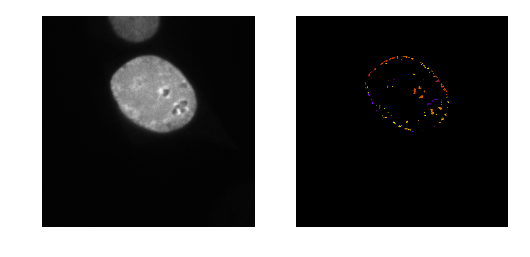

In [72]:
#Compare side by side
plt.subplot(1,2,1), plt.imshow(GFP_stack[16,1500:2000,500:1000], cmap='gray')
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,2), plt.imshow(real_blobs[16,1500:2000,500:1000], cmap='gnuplot')
plt.subplot(1,2,2), plt.axis('off')

In [28]:
Spots = getPunctaProperties(GFP_stack, real_blobs)

In [29]:
#Assign each puncta to its cognate hull
Spots.insert(0, "Hull", pd.to_numeric(assignPuncta(real_blobs, shells)))

In [54]:
Spots

,Hull,Puncta,Center_x,Center_y,Center_z,volume,mean_GFP,integrated_GFP,threshold_GFP,false_puncta
0,3,1,399,885,4,471,3051.949045,1437468.0,1382.934422,False
1,3,2,362,900,2,70,1227.842857,85949.0,1382.934422,True
2,3,3,378,906,2,138,1815.623188,250556.0,1382.934422,False
3,3,4,366,920,1,18,1307.388889,23533.0,1382.934422,True
4,3,5,372,965,3,22,1457.590909,32067.0,1382.934422,False
5,3,6,372,985,4,92,1132.108696,104154.0,1382.934422,True
6,3,7,353,986,1,10,1059.900000,10599.0,1382.934422,True
7,3,8,369,991,1,32,1084.187500,34694.0,1382.934422,True
8,21,9,771,1640,2,46,1627.500000,74865.0,1143.622450,False
9,21,10,769,1649,4,219,2383.050228,521888.0,1143.622450,False


In [51]:
temp=[]

for Hull in Spots['Hull']:
    #print Hull
    t = Shell_Properties["threshold_GFP"].loc[Shell_Properties['Hull']==Hull].item()
    #print t
    temp.append(t)
    
Spots['threshold_GFP']=temp

In [53]:
Spots['false_puncta']=Spots['mean_GFP']<Spots['threshold_GFP']

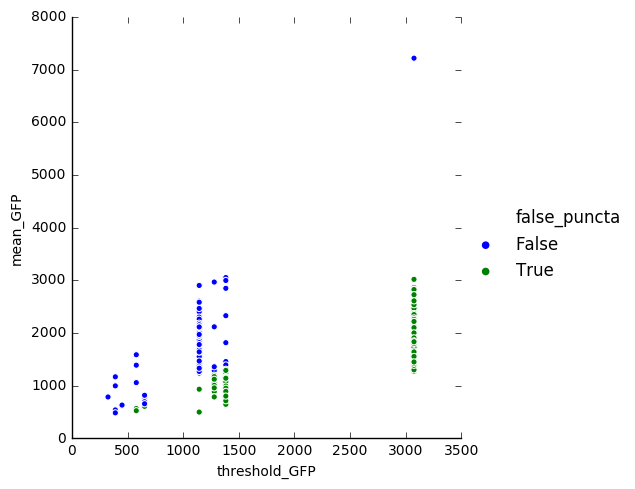

In [61]:
# plt.scatter('threshold_GFP', 'mean_GFP', data=Spots)
sns.relplot(x="threshold_GFP", y="mean_GFP", hue='false_puncta', data=Spots);

In [ ]:
##Where are the false positives? This code is super inefficient!!

#Color blobs by truth
blob_judge=np.zeros_like(real_blobs)

for b in range(1,real_blobs.max()+1):
    judge = (Spots["false_puncta"].loc[Spots['Puncta']==b].item() + 1)*100
    blob_judge[real_blobs==b] = judge

(<matplotlib.axes._subplots.AxesSubplot at 0x18b5a588>,
 (-0.5, 499.5, 499.5, -0.5))

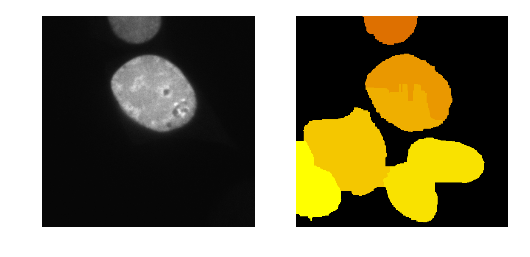

In [79]:
#Compare side by side
plt.subplot(1,2,1), plt.imshow(GFP_stack[18,1500:2000,500:1000], cmap='gray')
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,2), plt.imshow(shells[18,1500:2000,500:1000], cmap='gnuplot')
plt.subplot(1,2,2), plt.axis('off')

(<matplotlib.axes._subplots.AxesSubplot at 0x196acf98>,
 (-0.5, 499.5, 499.5, -0.5))

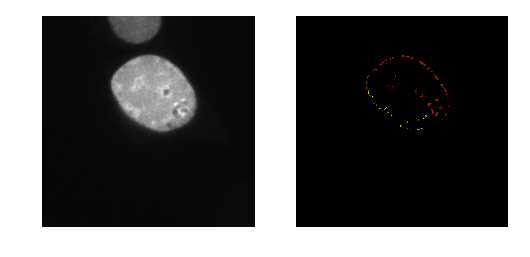

In [80]:
#Compare side by side
plt.subplot(1,2,1), plt.imshow(GFP_stack[18,1500:2000,500:1000], cmap='gray')
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,2), plt.imshow(blob_judge[18,1500:2000,500:1000], cmap='gnuplot')
plt.subplot(1,2,2), plt.axis('off')

In [35]:
##Can we add more data during the aggregation phase?
aggy2 = {'mean_GFP' : {'n_Puncta' : 'count',
                        'mean_Puncta_GFP': 'mean',
                          'std_Puncta_GFP' : 'std'
                      },
        'volume': {'mean_Puncta_volume': 'mean',
                  'std_Puncta_volume': 'std'}
        }

aggs2 = Spots.groupby(['Hull']).agg(aggy2)

##Rename the columns to simplify referencing after merge
aggs2.columns=['std_Puncta_volume','mean_Puncta_volume','mean_Puncta_GFP','n_Puncta','std_Puncta_GFP']

#Reorder the columns
aggs2=aggs2[[3,2,4,1,0]]
aggs2

,n_Puncta,mean_Puncta_GFP,std_Puncta_GFP,mean_Puncta_volume,std_Puncta_volume
Hull,,,,,
3,42,1252.910075,558.625258,112.523810,198.026266
4,6,950.347323,464.002654,174.833333,191.662638
7,13,692.518255,66.735057,37.923077,27.548326
17,1,785.416667,NaN,12.000000,NaN
18,2,627.784444,5.509147,21.500000,4.949747
19,19,1208.003919,512.988364,149.894737,323.376268
20,4,797.095514,337.388286,186.750000,200.813969
21,164,1872.770843,353.642986,89.012195,156.758968
22,154,2225.124734,567.640027,88.727273,320.714710


In [89]:
#Convert Well, Stack and Hull info to a multilevel index
All_Hulls.set_index(['Well', 'Stack', 'Hull'], drop=True, inplace=True)

In [90]:
##Add aggregate data to the All_Hulls dataframe
All_Hulls2=pd.concat([All_Hulls, aggs2], axis=1)

In [91]:
#Replace NaN values with 0
All_Hulls2['n_Puncta'].fillna(value=0, inplace=True)

In [92]:
All_Hulls2['Punctate'] = All_Hulls2['n_Puncta']>0

In [36]:
def annotateHulls(hulls_dataframe):
    
    ##Add aggregate data to the All_Hulls dataframe
    df2=pd.concat([hulls_dataframe, aggs2], axis=1)
    
    #Replace NaN values with 0
    df2['n_Puncta'].fillna(value=0, inplace=True)
    
    df2['Punctate'] = df2['n_Puncta']>0
    
    return df2

In [38]:
#Incorrect merge
df2 = annotateHulls(Shell_Properties)
df2

,Hull,Center_x,Center_y,Center_z,volume,integrated_GFP,mean_GFP,std_GFP,median_GFP,threshold_GFP,n_Puncta,mean_Puncta_GFP,std_Puncta_GFP,mean_Puncta_volume,std_Puncta_volume,Punctate
0,1,710,477,17,407159,70593554.0,173.380802,26.189977,177.0,216.284965,0.0,NaN,NaN,NaN,NaN,False
1,2,319,626,7,14409,1566929.0,108.746547,5.617497,108.0,116.426246,0.0,NaN,NaN,NaN,NaN,False
2,3,682,916,17,656932,535977599.0,815.879876,339.956282,873.0,1382.934422,0.0,NaN,NaN,NaN,NaN,False
3,4,991,864,17,655442,248918593.0,379.772113,118.597136,400.0,577.895704,42.0,1252.910075,558.625258,112.523810,198.026266,True
4,5,862,877,17,153204,18325700.0,119.616329,8.564670,119.0,131.847006,6.0,950.347323,464.002654,174.833333,191.662638,True
5,6,611,1070,17,1592873,289940176.0,182.023411,92.778361,120.0,259.167541,0.0,NaN,NaN,NaN,NaN,False
6,7,768,1075,17,236973,87698210.0,370.076802,154.343689,421.0,652.515534,0.0,NaN,NaN,NaN,NaN,False
7,8,989,1009,17,1009655,138943028.0,137.614361,39.269059,131.0,189.903588,13.0,692.518255,66.735057,37.923077,27.548326,True
8,9,779,1018,17,865893,143149310.0,165.319861,44.274787,172.0,238.412180,0.0,NaN,NaN,NaN,NaN,False
9,10,1422,1269,17,212979,27707748.0,130.096150,13.373527,129.0,149.060291,0.0,NaN,NaN,NaN,NaN,False


**Iterate through files**

In [33]:
[All_Hulls, All_Spots] = batchDetectPuncta(filelist, shell_list, newpath)

Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_000_000.ome.tif
There is no unique hull file for this input image
Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_000_001.ome.tif
There is no unique hull file for this input image
Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_000_002.ome.tif
There is no unique hull file for this input image
Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_001_000.ome.tif
There is no unique hull file for this input image
Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_001_001.ome.tif
There is no unique hull file for this input image
Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_001_002.ome.tif
There is no unique hull file for this input image
Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_002_000.ome.tif
There is no unique hull file for this input image
Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_002_001.ome.tif
There is no unique hull file for this input image
Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_002_002.ome.tif
There is no unique hull file for this input image
Processed


**Congratulations!!**

You have done the heavy lifting.

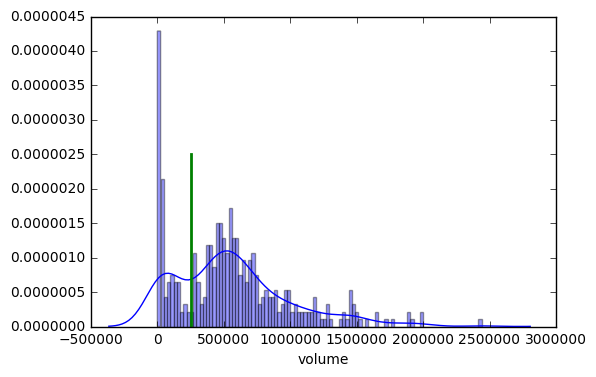

In [84]:
sns.distplot(All_Hulls['volume'], bins=100)
plt.plot([250000, 250000], [0, 0.0000025], linewidth=2)

[A] Calculate puncta properties for each nucleus

In [85]:
#Count Puncta in each nuceli
aggs = All_Spots.groupby(['Well', 'Stack', 'Hull'])['Puncta'].count()

In [86]:
##Can we add more data during the aggregation phase?
aggy2 = {'mean_GFP' : {'n_Puncta' : 'count',
                        'mean_Puncta_GFP': 'mean',
                          'std_Puncta_GFP' : 'std'
                      },
        'volume': {'mean_Puncta_volume': 'mean',
                  'std_Puncta_volume': 'std'}
        }

aggs2 = All_Spots.groupby(['Well', 'Stack', 'Hull']).agg(aggy2)

##Rename the columns to simplify referencing after merge
aggs2.columns=['std_Puncta_volume','mean_Puncta_volume','mean_Puncta_GFP','n_Puncta','std_Puncta_GFP']

#Reorder the columns
aggs2=aggs2[[3,2,4,1,0]]
aggs2

n_Puncta  mean_Puncta_GFP  std_Puncta_GFP  \
Well   Stack Hull                                              
Well02 1     33           1       616.294118             NaN   
       2     9          283      3072.961493      536.368013   
             10         109      2773.502126      454.946385   
             15           1       703.275000             NaN   
             18         349      2167.532229      301.982063   
             29           1       589.866667             NaN   
             31           3       774.306745       16.654990   
Well03 1     13          16       796.977984       51.631764   
             19           1       650.860000             NaN   
             21           2       640.819597       18.803083   
             22          28       974.137476       90.250426   
       3     9           11       895.818004       79.766637   
             10          80      1399.529390      408.553687   
             24         163      1835.775112      920.051122   
             25          22       790.542048       83.533905   
Well04 1     32         137      1813.242224      720.801802   
             38         180      3676.127412     1292.879025   
             39         194      3248.536511     1124.726193   
       2     11          33      1020.437348      198.179018   
             14           1       727.056604             NaN   
             15           1       782.000000             NaN   
             35          39      1675.059050      851.521422   
             36          97      2196.566276      708.263316   
             51          43      1220.121407      304.419560   
       3     4           18      1248.538960      205.729065   
             13          10       816.166853       59.322602   

                   mean_Puncta_volume  std_Puncta_volume  
Well   Stack Hull                                         
Well02 1     33             34.000000                NaN  
       2     9             173.784452         349.850038  
             10            179.256881         283.650979  
             15             40.000000                NaN  
             18            137.275072         252.244896  
             29             30.000000                NaN  
             31             31.333333           1.527525  
Well03 1     13             52.000000          23.105555  
             19             50.000000                NaN  
             21             57.500000           7.778175  
             22             67.535714          40.793502  
       3     9              85.363636          60.399127  
             10            122.437500         176.890357  
             24            140.773006         246.181663  
             25             92.272727          69.521618  
Well04 1     32             89.591241         114.304389  
             38            158.972222         126.223241  
             39            203.706186         322.794279  
       2     11             80.272727          66.686427  
             14             53.000000                NaN  
             15             37.000000                NaN  
             35             85.307692          89.285218  
             36            144.907216         210.159021  
             51             84.813953          71.930607  
       3     4             116.166667         127.886094  
             13             69.300000          30.951755

In [87]:
##Save All_Hulls
All_Hulls.to_csv(newpath+"_All_Hulls.csv")

In [89]:
#Convert Well, Stack and Hull info to a multilevel index
All_Hulls.set_index(['Well', 'Stack', 'Hull'], drop=True, inplace=True)

In [90]:
##Add aggregate data to the All_Hulls dataframe
All_Hulls2=pd.concat([All_Hulls, aggs2], axis=1)

In [91]:
#Replace NaN values with 0
All_Hulls2['n_Puncta'].fillna(value=0, inplace=True)

In [92]:
All_Hulls2['Punctate'] = All_Hulls2['n_Puncta']>0

In [93]:
#To colour plots by MultiLevel index, use .reset_index()
df2=All_Hulls2.reset_index()

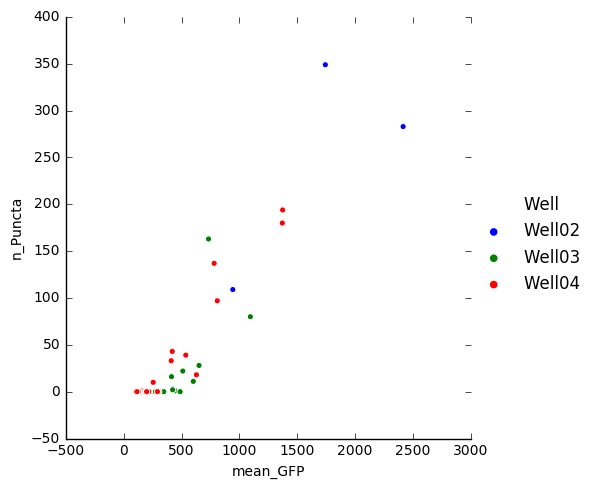

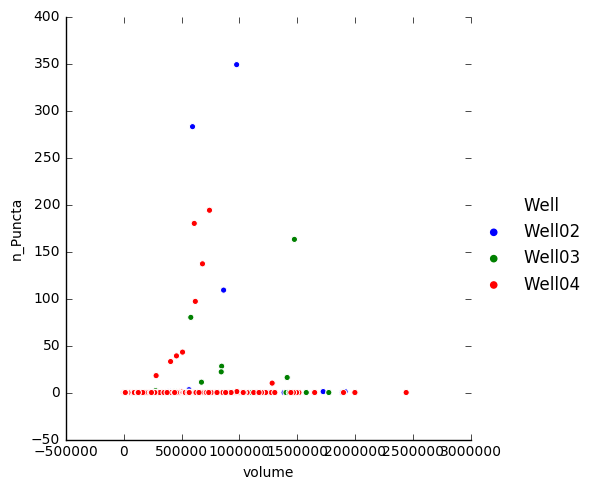

In [94]:
##Number of puncta scale with expression but not with nuclear volume
# sns.relplot(x="mean_GFP", y="n_Puncta", data=All_Hulls2);
# sns.relplot(x="mean_GFP", y="mean_Puncta_GFP", data=All_Hulls2);
# sns.relplot(x="volume", y="n_Puncta", data=All_Hulls2);
sns.relplot(x="mean_GFP", y="n_Puncta", hue='Well', data=df2);
sns.relplot(x="volume", y="n_Puncta", hue='Well', data=df2);
# plt.plot([2000000, 2000000], [0, 500], linewidth=2)

In [95]:
sns.relplot(x="volume", y="mean_GFP", hue='Punctate', data=Nuclei);

NameError: name 'Nuclei' is not defined

[B] Calculate nuclear properties for each puncta

In [96]:
df3=All_Spots.reset_index(drop=True)

In [101]:
df3

,Well,Stack,Hull,Puncta,Center_x,Center_y,Center_z,volume,mean_GFP,integrated_GFP
0,Well02,1,33,1.0,356.0,1383.0,21.0,34.0,616.294118,20954.0
1,Well02,2,9,1.0,483.0,428.0,5.0,169.0,2706.940828,457473.0
2,Well02,2,9,2.0,480.0,437.0,4.0,181.0,2723.215470,492902.0
3,Well02,2,9,3.0,464.0,433.0,2.0,59.0,2013.000000,118767.0
4,Well02,2,9,4.0,490.0,444.0,4.0,138.0,2719.963768,375355.0
5,Well02,2,10,5.0,508.0,447.0,2.0,38.0,2200.263158,83610.0
6,Well02,2,10,6.0,516.0,451.0,8.0,381.0,2955.986877,1126231.0
7,Well02,2,9,7.0,475.0,457.0,3.0,117.0,2928.034188,342580.0
8,Well02,2,9,8.0,457.0,460.0,7.0,349.0,4161.908309,1452506.0
9,Well02,2,10,9.0,509.0,460.0,2.0,39.0,2369.538462,92412.0


In [102]:
##Save All_Spots
df3.to_csv(newpath+"_All_Spots.csv")

In [97]:
#Merge df2 and df3 on three columns
df4=pd.merge(left=df2, right=df3, on=['Well','Stack','Hull'], suffixes=['','_Puncta'])
df4.columns

Index([u'Well', u'Stack', u'Hull', u'Center_x', u'Center_y', u'Center_z',
       u'volume', u'integrated_GFP', u'mean_GFP', u'std_GFP', u'median_GFP',
       u'threshold_GFP', u'n_Puncta', u'mean_Puncta_GFP', u'std_Puncta_GFP',
       u'mean_Puncta_volume', u'std_Puncta_volume', u'Punctate', u'Puncta',
       u'Center_x_Puncta', u'Center_y_Puncta', u'Center_z_Puncta',
       u'volume_Puncta', u'mean_GFP_Puncta', u'integrated_GFP_Puncta'],
      dtype='object')

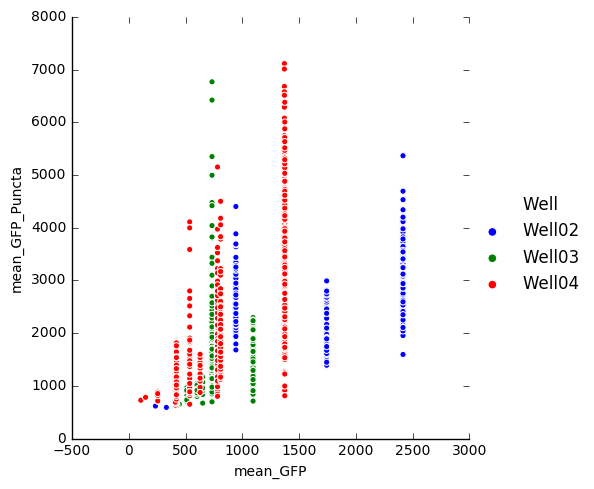

In [98]:
##All puncta
sns.relplot(x="mean_GFP", y="mean_GFP_Puncta", hue='Well', data=df4);

[C] Calculate the attrition rate Nuclei>Useable Nuclei>Of which transfected>Of which have puncta 

In [301]:
# print len(All_Hulls2)
# Full_z=All_Hulls2[All_Hulls2["Center_z"]==12] #Exclude partial
# print len(Full_z) 
# print len(Full_z[Full_z["volume"]>250000]) #Exclude small

# Nuclei=Full_z[Full_z["volume"].between(250000,2000000)] #Excluding small and big
# print len(Nuclei) 

# Transfected = Nuclei[Nuclei['mean_GFP']>150] #Exclude untransfected
# print len(Transfected)

# print len(Transfected[Transfected['Punctate']])

334
284
247
225
35
15


In [367]:
#Import Exp0104 platemap as pd.dataframe
Exp0104=pd.read_csv('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Exp0104_KDM5A_plate_map.csv')
Exp0104
#TODO add sequence files to platemap

,Well,Construct,Plasmid,Notes
0,Well01,flKDM5A,F00183,"puncta and some hollow puncta, odd anuclear ho..."
1,Well02,PHD2-IDR-PHD3,mini2,"some puncta, particularly in bright cells"
2,Well03,PHD2-IDR-PHD3[W1625A],mini1,Well03_2_is_garbage
3,Well04,PHD2-IDR,mini2,"Puncta, cell to cell heterogenetiy"
4,Well05,CTR,F00188,Plasmids mixed up. Do not analyse!!
5,Well06,CTR3,F00189,Plasmids mixed up. Do not analyse!! Seemed les...
6,Well07,CTR4,F00190,Plasmids mixed up. Do not analyse!! Mobile pun...
7,Well08,flKDM5A[H483A],F00184,NaN


In [374]:
##Annotate Wells with relevant Construct details
def lookup_construct(well):
    match = (Exp0104['Well'] == well)
    construct = Exp0104['Construct'][match]
    return construct.values[0]

df4['Construct'] = df4['Well'].apply(lookup_construct)

In [387]:
##Save df4
df4.to_csv(newpath+"_All_Spots.csv")

In [37]:
##Load df4 'All_Spots'
df4 = pd.read_csv(newpath+"_All_Spots.csv")

In [40]:
df4

,Unnamed: 0,Well,Stack,Hull,Puncta,Center_x,Center_y,Center_z,volume,mean_GFP,integrated_GFP
0,0,Well02,1,33,1.0,356.0,1383.0,21.0,34.0,616.294118,20954.0
1,1,Well02,2,9,1.0,483.0,428.0,5.0,169.0,2706.940828,457473.0
2,2,Well02,2,9,2.0,480.0,437.0,4.0,181.0,2723.215470,492902.0
3,3,Well02,2,9,3.0,464.0,433.0,2.0,59.0,2013.000000,118767.0
4,4,Well02,2,9,4.0,490.0,444.0,4.0,138.0,2719.963768,375355.0
5,5,Well02,2,10,5.0,508.0,447.0,2.0,38.0,2200.263158,83610.0
6,6,Well02,2,10,6.0,516.0,451.0,8.0,381.0,2955.986877,1126231.0
7,7,Well02,2,9,7.0,475.0,457.0,3.0,117.0,2928.034188,342580.0
8,8,Well02,2,9,8.0,457.0,460.0,7.0,349.0,4161.908309,1452506.0
9,9,Well02,2,10,9.0,509.0,460.0,2.0,39.0,2369.538462,92412.0


In [41]:
Full_z=df4[df4["Center_z"]==12] #Exclude partial
Nuclei=Full_z[Full_z["volume"].between(250000,2000000)] #Excluding small and big
Transfected = Nuclei[Nuclei['mean_GFP']>150] #Exclude untransfected
#13 nuclei are left
Transfected["Hull"].value_counts()

Series([], Name: Hull, dtype: int64)

In [29]:
sns.set_style("ticks")
sns.relplot(x="mean_GFP", y="mean_GFP_Puncta", hue='Construct', data=Transfected);
plt.gca()
plt.xlabel('Nuclear GFP (Mean)')
plt.ylabel('Focus GFP (Mean)')

ValueError: Could not interpret input 'mean_GFP_Puncta'

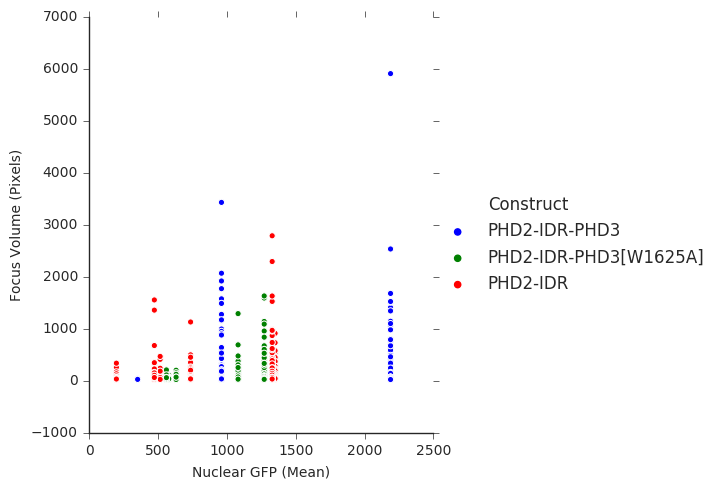

In [382]:
sns.set_style("ticks")
sns.relplot(x="mean_GFP", y="volume_Puncta", hue='Construct', data=Transfected);
plt.gca()
plt.xlabel('Nuclear GFP (Mean)')
plt.ylabel('Focus Volume (Pixels)')

In [99]:
sns.set_style("ticks")
sns.relplot(x="volume_Puncta", y="mean_GFP_Puncta", hue='Construct', alpha=0.4, data=Transfected);
plt.gca()
plt.xlabel('Focus Volume log10(Pixels)')
plt.ylabel('Focus GFP (Mean)')
plt.xscale("log")

NameError: name 'Transfected' is not defined

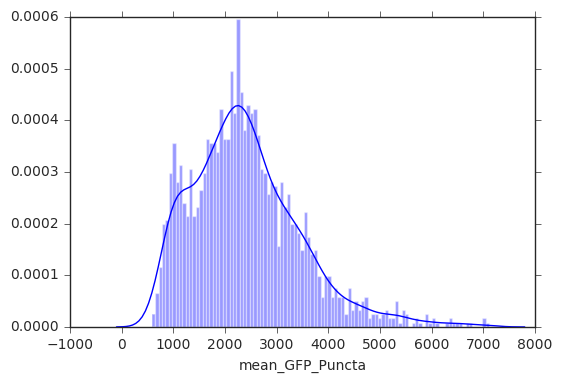

In [390]:
##Compare the distributions of Focus intensity
sns.distplot(Transfected['mean_GFP_Puncta'], bins=100)

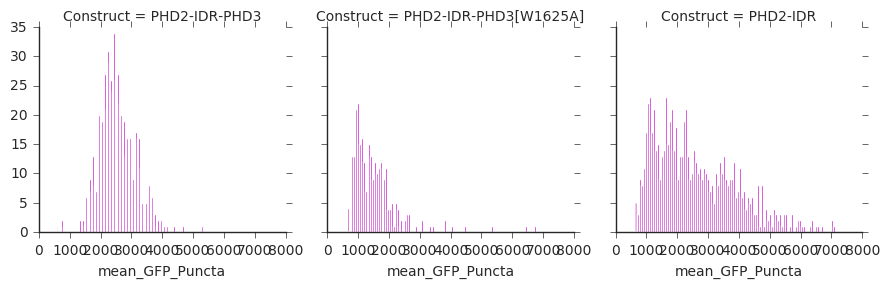

In [392]:
g = sns.FacetGrid(Transfected, col="Construct", col_order=["PHD2-IDR-PHD3", "PHD2-IDR-PHD3[W1625A]", "PHD2-IDR"])
g = g.map(plt.hist, "mean_GFP_Puncta", bins=100, color="m")

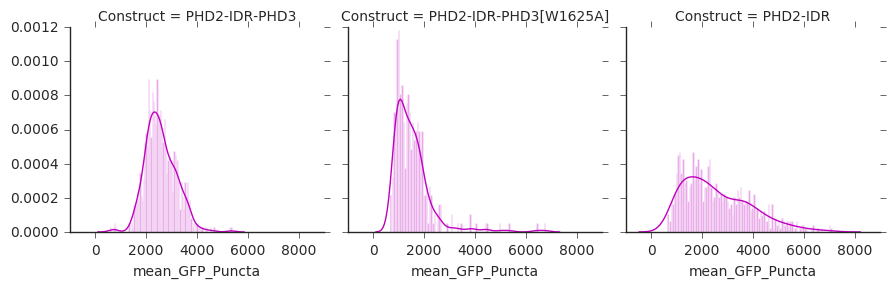

In [394]:
g = sns.FacetGrid(Transfected, col="Construct", col_order=["PHD2-IDR-PHD3", "PHD2-IDR-PHD3[W1625A]", "PHD2-IDR"])
g = g.map(sns.distplot, "mean_GFP_Puncta", bins=100, color="m")

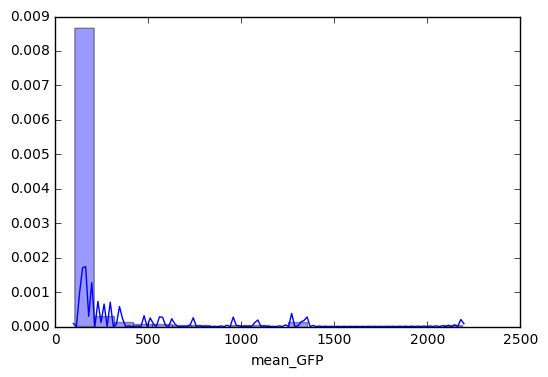

In [295]:
sns.distplot(Nuclei['mean_GFP'], bins=20)

[D] Calculate insignificance of observations

In [100]:
All_Hulls

Center_x  Center_y  Center_z   volume  integrated_GFP  \
Well   Stack Hull                                                          
Well02 1     1         1281       163        12   678521      71684913.0   
             2         1238       355        12   554398      75171985.0   
             3         1034       342        12   395504      94757759.0   
             4         1402       444        12   405736      49072664.0   
             5         1568       489        12   291996      30700277.0   
             6         1863       517        12   333230      34887212.0   
             7          928       538        12   502707      53720090.0   
             8         1715       622        12   688563      72459026.0   
             9         1090       584        12   497598     100203558.0   
             10        1185       662        12   327380      34983486.0   
             11        1174       662        12   422265      44386012.0   
             12        1302       672        12   387350      40604779.0   
             13         743       720        11   121791      13120992.0   
             14        1048       708        12   395500      41831836.0   
             15        1342       796        12  1010720     107853037.0   
             16        1583       806        12   607744      63699339.0   
             17         486       779        12    11920       1419246.0   
             18         809       837        12   996154     108776397.0   
             19        1431       882        12   287412      30242676.0   
             20        1650      1004        12   646894      67824659.0   
             21        1457      1066        12  1183369     125572079.0   
             22         851      1009        12   650083      92311643.0   
             23         513       994        12   613875     213346012.0   
             24        1858      1066        12   394216      41222256.0   
             25         959      1280        12  1492158     159050946.0   
             26         447      1126        12   389767      92352751.0   
             27         666      1154        12   465145     104409445.0   
             28        1498      1165        12   543660      57251930.0   
             29         845      1221        12   469860      52608179.0   
             30         401      1189         5    30946       8375138.0   
...                     ...       ...       ...      ...             ...   
Well04 2     66        1174        70        16    69599       7466958.0   
             67        1904        72        23    31861       3330620.0   
       3     1          824       638        12  1444655     153523691.0   
             2          662       693        12  1191340     125748890.0   
             3         1176       745        12    89069      11097507.0   
             4         1283       825        12   280083     175899630.0   
             5          758       799        12    20113       2190733.0   
             6         1218       924        12  1066152     213209534.0   
             7          891       872        12   164620      17922104.0   
             8          732       914        12    90719       9918471.0   
             9          829       991        12   880709     191448425.0   
             10         462      1052        12   456602      48296288.0   
             11         596      1003        12   440040      46724276.0   
             12         826      1024        10    32323       3866945.0   
             13         990      1185        12  1282840     326599090.0   
             14        1271      1244        12   617004      70056892.0   
             15        1204      1138        12   120675      14330827.0   
             16         585      1227        12   625153      67167782.0   
             17         402      1257        12   566224      59697984.0   
             18         998      1379        12  1041892     303877

In [143]:
#Stack is a categorical
All_Hulls["Stack"]=All_Hulls.Stack.astype('category')
All_Spots["Stack"]=All_Spots.Stack.astype('category')

In [307]:
All_Hulls2[All_Hulls2['Punctate']].head()

Center_x  Center_y  Center_z   volume  integrated_GFP  \
Well   Stack Hull                                                          
Well02 1     26         586      1522        12  4049703    7.535963e+08   
       2     7          469       547        12  1138404    2.490973e+09   
             12         700       771        12  1905270    6.690441e+08   
             17         717      1155        12  1936059    1.859652e+09   
             24         608      1627        12  1125950    3.961101e+08   

                      mean_GFP     std_GFP  median_GFP  threshold_GFP  \
Well   Stack Hull                                                       
Well02 1     26     186.086803   85.784578       146.0     274.676868   
       2     7     2188.127201  761.258244      2312.0    3453.887366   
             12     351.154468  119.653290       308.0     487.479935   
             17     960.534527  855.992980       716.0    1999.989471   
             24     351.800784  124.450667       378.0     564.676001   

                   n_Puncta  mean_Puncta_GFP  std_Puncta_GFP  \
Well   Stack Hull                                              
Well02 1     26         1.0       616.294118             NaN   
       2     7        444.0      2917.083396      539.553376   
             12         1.0       703.275000             NaN   
             17       345.0      2163.854803      308.172023   
             24         4.0       728.196725       93.217281   

                   mean_Puncta_volume  std_Puncta_volume Punctate  
Well   Stack Hull                                                  
Well02 1     26             34.000000                NaN     True  
       2     7             174.966216         378.074427     True  
             12             40.000000                NaN     True  
             17            149.828986         315.013025     True  
             24             31.000000           1.414214     True

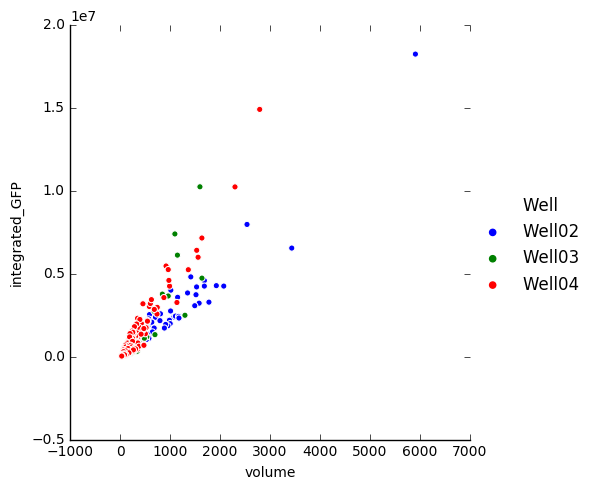

In [149]:
sns.relplot(x="volume", y="integrated_GFP", hue='Well', data=All_Spots);

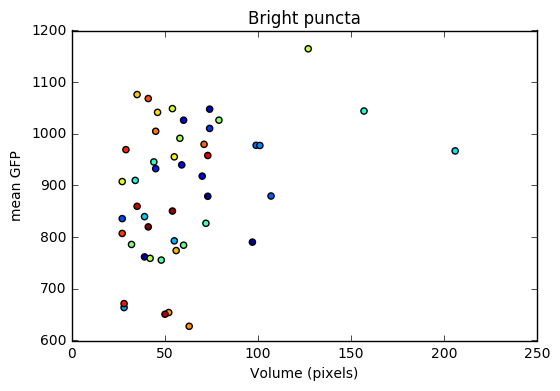

In [42]:
#Plot mean_GFP against size
plt.scatter(Puncta_Properties['volume'], Puncta_Properties['mean_GFP'], c=Puncta_Properties.index)
plt.xlabel("Volume (pixels)")
plt.ylabel("mean GFP")
plt.title("Bright puncta")

In [54]:
##Identify hollow puncta!!
#Fill and measure volume again. This didn't work
# from scipy.ndimage.morphology import binary_fill_holes

# full_blobs = binary_fill_holes(real_blobs)

**Examine the data with plots**

(array([ 16.,  15.,   9.,   1.,   3.,   1.,   0.,   1.,   0.,   1.]),
 array([  27. ,   44.9,   62.8,   80.7,   98.6,  116.5,  134.4,  152.3,
         170.2,  188.1,  206. ]),
 <a list of 10 Patch objects>)

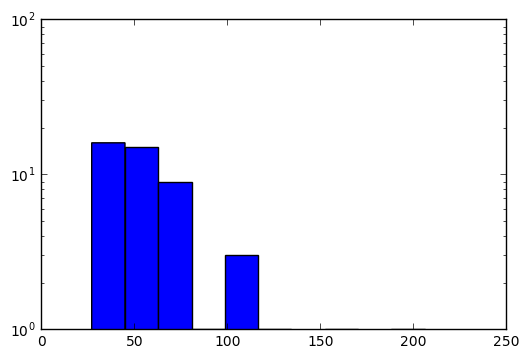

In [47]:
plt.hist(Puncta_Properties['volume'], log=True)

(array([  7.,  12.,  27.,  38.,  34.,  43.,  47.,  38.,  47.,  36.,  31.,
         43.,  27.,  32.,  37.,  38.,  45.,  44.,  46.,  41.,  51.,  44.,
         44.,  60.,  50.,  72.,  55.,  46.,  52.,  50.,  51.,  45.,  37.,
         36.,  31.,  34.,  33.,  19.,  34.,  28.,  31.,  24.,  24.,  22.,
         18.,  27.,  21.,  17.,  18.,  12.,   7.,  12.,  12.,   7.,   9.,
          7.,   7.,   3.,   9.,   4.,   6.,   4.,   6.,   7.,   2.,   3.,
          3.,   2.,   3.,   4.,   2.,   2.,   6.,   1.,   4.,   3.,   0.,
          1.,   2.,   1.,   0.,   3.,   1.,   2.,   1.,   0.,   0.,   1.,
          2.,   1.,   1.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   2.,
          1.]),
 array([  589.86666667,   655.1234359 ,   720.38020513,   785.63697436,
          850.89374359,   916.15051282,   981.40728205,  1046.66405128,
         1111.92082051,  1177.17758974,  1242.43435897,  1307.69112821,
         1372.94789744,  1438.20466667,  1503.4614359 ,  1568.71820513,
         1633.97497436,  1699.

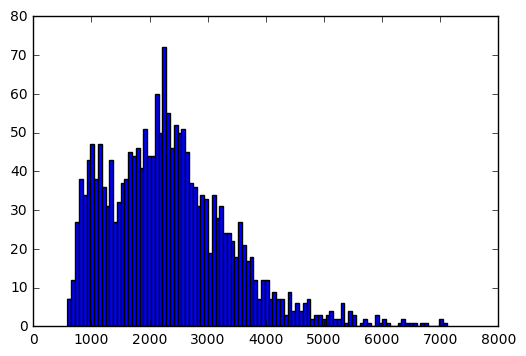

In [151]:
plt.hist(All_Spots['mean_GFP'], bins=100)

(array([  6.,  10.,   8.,   4.,   5.,   4.,   4.,   0.,   3.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([  18586. ,   27616.2,   36646.4,   45676.6,   54706.8,   63737. ,
          72767.2,   81797.4,   90827.6,   99857.8,  108888. ,  117918.2,
         126948.4,  135978.6,  145008.8,  154039. ,  163069.2,  172099.4,
         181129.6,  190159.8,  199190. ]),
 <a list of 20 Patch objects>)

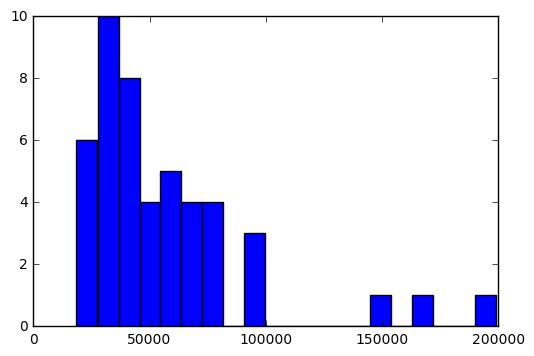

In [48]:
plt.hist(Puncta_Properties['integrated_GFP'], bins=20)

In [50]:
Hull_Properties.loc[[14,16,18],:]

,Center_x,Center_y,Center_z,volume,integrated_GFP,mean_GFP,std_GFP,median_GFP,threshold_GFP
14,1044,1023,12,729341,421648818.0,578.123015,167.156076,602.0,852.734114
16,965,1377,12,4072787,748717513.0,183.834193,130.900396,126.0,322.350594
18,567,1530,12,891818,562785220.0,631.053892,217.417173,677.0,1003.125759


In [124]:
##Calculate puncta metrics with respect to 'Hull'
a = np.array(Puncta_Properties["volume"].astype(float))
b = np.array(Hull_Properties.loc[Puncta_Properties["Hull"],"volume"].astype(float))
c = np.divide(np.array(Puncta_Properties["volume"].astype(float)),np.array(Hull_Properties.loc[Puncta_Properties["Hull"],"volume"].astype(float)))

#Check calculation
# temp_d = np.transpose([a, b, c])
# temp_h = ["Puncta_Volume", "Hull_Volume", "Fraction"]
# temp=pd.DataFrame(temp_d, columns=temp_h)
# temp

In [52]:
Puncta_Properties["hull_volume"] = np.array(Hull_Properties.loc[Puncta_Properties["Hull"],"volume"].astype(float))
Puncta_Properties["fraction_hull_volume"] = PunctaByHull("volume","volume")

Puncta_Properties["hull_mean_GFP"] = np.array(Hull_Properties.loc[Puncta_Properties["Hull"],"mean_GFP"].astype(float))
Puncta_Properties["Relative_GFP"] = PunctaByHull("mean_GFP","mean_GFP")

Puncta_Properties["hull_integrated_GFP"] = np.array(Hull_Properties.loc[Puncta_Properties["Hull"],"integrated_GFP"].astype(float))
Puncta_Properties["fraction_GFP_intensity"] = PunctaByHull("integrated_GFP","integrated_GFP")

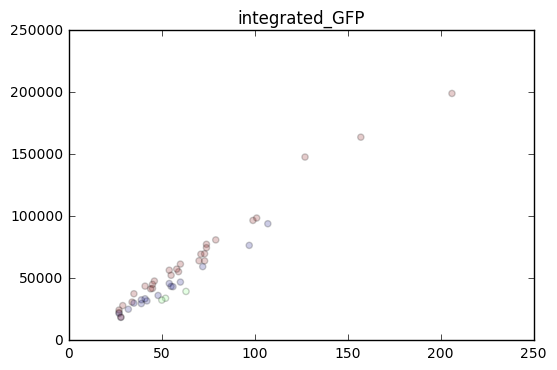

In [53]:
##Compare puncta size between cells
fig, ax = plt.subplots()
plt.scatter('volume', 'integrated_GFP', c='Hull', alpha=0.2, data=Puncta_Properties)
ax.set_title('integrated_GFP')
#ax.set_xlim((0,500))
#plt.legend()

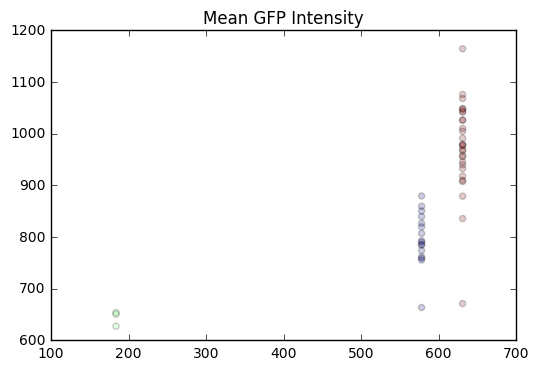

In [54]:
##Compare puncta size between cells
fig, ax = plt.subplots()
plt.scatter('hull_mean_GFP', 'mean_GFP', c='Hull', alpha=0.2, data=Puncta_Properties)
ax.set_title('Mean GFP Intensity')
#ax.set_xlim((0,500))
#plt.legend()

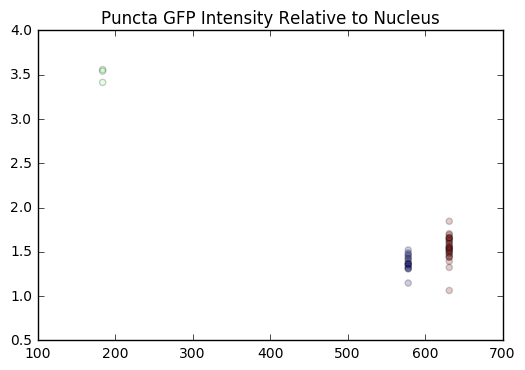

In [55]:
fig, ax = plt.subplots()
plt.scatter('hull_mean_GFP', 'Relative_GFP', c='Hull', alpha=0.2, data=Puncta_Properties)
ax.set_title('Puncta GFP Intensity Relative to Nucleus')

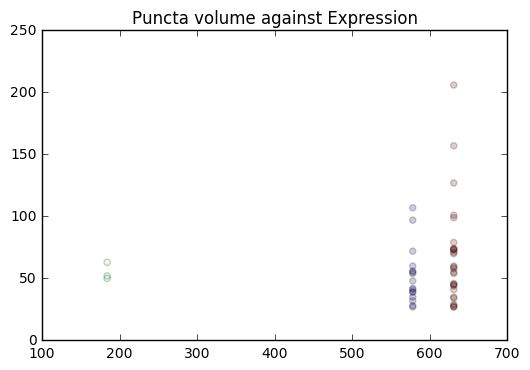

In [56]:
fig, ax = plt.subplots()
plt.scatter('hull_mean_GFP', 'volume', c='Hull', alpha=0.2, data=Puncta_Properties)
ax.set_title('Puncta volume against Expression')

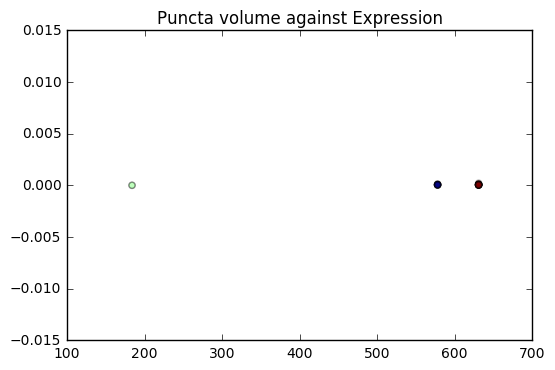

In [57]:
fig, ax = plt.subplots()
plt.scatter('hull_mean_GFP', 'fraction_hull_volume', c='Hull', alpha=0.2, data=Puncta_Properties)
ax.set_title('Puncta volume against Expression')

In [396]:
Mask5=np.load('C:\Users\David Brown\Documents\Huang Lab\Exp0104_KDM5A_PHD2-fragments\Output\Well02_HeLa_PHD2-IDR-PHD3_1_Mask5.npy')

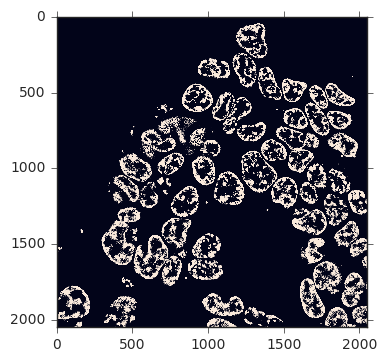

In [398]:
plt.imshow(Mask5[4])

In [402]:
Mask5.shape

(24L, 2048L, 2048L)

In [405]:
# create data
d = np.ndarray(shape=(10,20), dtype=np.float32) # also supports 64bit but ImageJ does not
d[()] = np.arange(200).reshape(10, 20)

d.shape

# save 32bit float (== single) tiff
#imsave('test.tif', d) #, description="hohoho")

(10L, 20L)

In [406]:
plt.imsave('C:\Users\David Brown\Documents\Huang Lab\Exp0104_KDM5A_PHD2-fragments\Output\Well02_HeLa_PHD2-IDR-PHD3_1_Mask5_z1.tiff', np.array(Mask5[0]), cmap='gray')